In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import wigpy

from src.tourism.ts_utils import *
from src.text.epu import *
from src.text.utils import *
from statsmodels.tsa.api import VAR

In [2]:
nlp = spacy.load("en_core_web_sm")
folderpath = os.getcwd() + "/data/text/solomon_islands/"
target_dir = os.getcwd() + "/outputs/text/solomon_islands/"

In [3]:
files_list = [
    folderpath +  file for file in os.listdir(folderpath)
    if "news" in file and "ner" not in file]

In [4]:
sepu = EPU(filepath=files_list, cutoff="2020-01-01")
sepu.get_epu_category(subset_condition="date >= '2015-01-01' and date < '2024-01-01'")
sepu.get_count_stats()
sepu.calculate_epu_score()

In [19]:
collect["date"] = pd.to_datetime(collect["date"], utc=True)

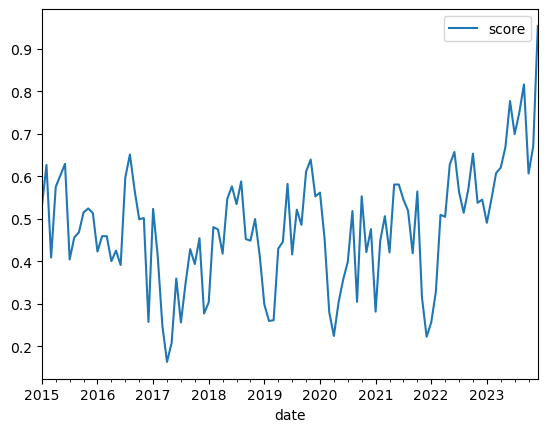

In [20]:
collect["econ_policy"] = collect["econ"] | collect["policy"]
score_df = pd.DataFrame()
for news in collect.news:
    news = str(news)
    scores = sid.polarity_scores(news)
    ss_temp = pd.DataFrame(scores, columns=scores.keys(), index=[0])
    if score_df.empty:
        score_df = ss_temp
    else:
        score_df = pd.concat([score_df, ss_temp], axis=0)
collect["score"] = score_df["compound"].tolist()
monthly_df = (collect[collect.econ_policy == True].set_index("date").groupby(
    pd.Grouper(freq="MS"))[["score"]].mean().reset_index())
monthly_df.plot(x="date", y="score")

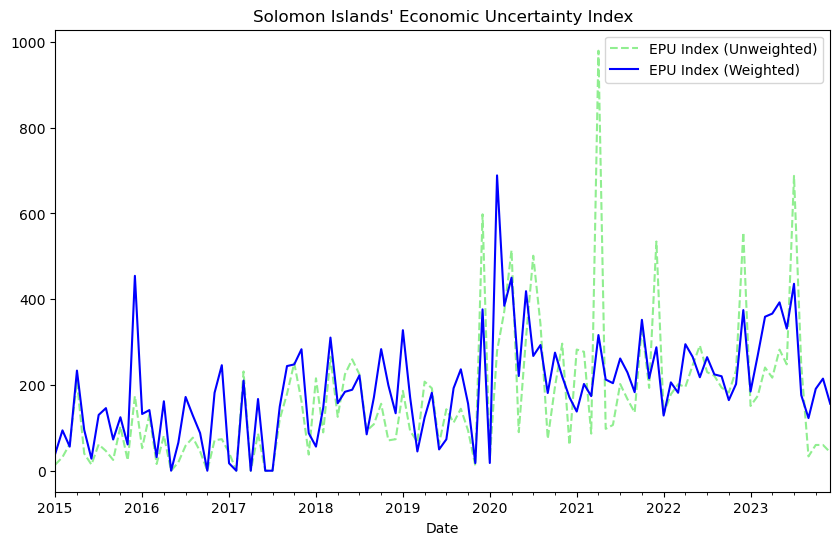

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
sepu.epu_stats.plot(x="date", y="epu_unweighted", ax=ax, color="lightgreen", linestyle="--");
sepu.epu_stats.plot(x="date", y="epu_weighted", ax=ax, color="blue");
plt.xlabel("Date")
plt.legend(["EPU Index (Unweighted)", "EPU Index (Weighted)"])
plt.title("Solomon Islands' Economic Uncertainty Index")
plt.show()
fig.savefig(target_dir+"sib_epu.jpg", dpi=400)

In [8]:
def check_entity_in_terms(row, terms):
    nlp = spacy.load('en_core_web_sm')
    if isinstance(row, str):
        doc = nlp(row)
        tokens = [token for token in doc]
        for token in tokens:
            lowered_token = str(token).lower()
            if lowered_token in terms and token.ent_type != 0:
                return True
            else:
                return False
    else:
        return False

## EPU -> Macroeconomic

In [185]:
si_cpi = [
    98.6, 99.0, 100.6, 100.7, 101.0, 100.6, 100.5, 100.1, 99.5, 99.6, 99.5,
    100.3, 102.0, 104.2, 103.9, 103.9, 103.0, 102.8, 103.0, 103.2, 104.1,
    104.0, 104.3, 104.4, 104.9, 104.1, 105.7, 104.8, 105.0, 105.1, 105.7,
    105.9, 106.3, 107.0, 107.5, 107.5, 114.2, 114.3, 114.1, 113.4, 112.2,
    107.6, 106.1, 105.3, 105.7, 105.6, 106.0, 104.5, 107.8, 111.6, 113.8,
    111.1, 110.8, 107.6, 106.9, 107.3, 108.0, 108.1, 108.2, 108.7, 109.8,
    110.4, 110.5, 112.7, 114.1, 114.3, 115.6, 117.6, 118.5, 119.8, 119.3,
    118.6, 120.3, 120.1, 120.0, 119.9, 119.6, 119.8, 120.9, 120.7, 120.9
]

si_infl_df = pd.DataFrame(pd.date_range("2017-01", "2023-09", freq="MS"),
                          columns=["date"])
si_infl_df["cpi"] = si_cpi
si_infl = si_infl_df.merge(sepu.epu_stats[["date", "epu_weighted"]],
                           how="left",
                           on="date")
si_infl["inflation"] = (si_infl["cpi"].diff().shift(-1) / si_infl["cpi"]) * 100

In [49]:
from src.google_trends import GT
from dotenv import load_dotenv
load_dotenv()

GoogleAPIkey = os.getenv("GoogleAPIkey")
gt = GT(GoogleAPIkey)

In [95]:
inflation_words = [
    "economy",
    "inflation", "inflation rate", "CPI", "fluctuation", "prices", "supply",
    "demand", "supply and demand", "price increases", "market trends", "economic outlook"
]

In [172]:
benchmark_term = "government"
geo_iso2 = "SB"
start_time = "2015-01"

benchmark_df = gt.to_df(gt.get_graph(benchmark_term, geo_iso2, start_time))
benchmark_df = benchmark_df.drop("term", axis=1).rename({"value": "benchmark"},
                                                        axis=1)

local_trends_df = pd.DataFrame()
for term in inflation_words:
    r = gt.get_graph(term, geo_iso2, start_time)
    r_df = gt.to_df(r)
    print(
        f"{term} : {(r_df.value==0).sum()} out of {len(r_df)} rows with zero values."
    )
    r_df = (r_df.drop("term", axis=1).rename({"value": term}, axis=1))

    if local_trends_df.empty:
        local_trends_df = r_df
    else:
        local_trends_df = local_trends_df.merge(r_df, how="left", on="date")

local_trends_df.columns = [
    col.lower().replace(" ", "_") for col in local_trends_df.columns
]

df = local_trends_df.merge(benchmark_df).drop("date", axis=1).fillna(0)

# Benchmark keyword volumes
svi_bt = df["benchmark"] / df["benchmark"].max()
svi_bj = df["benchmark"] / df.max(axis=1)

df["weight"] = (svi_bt / svi_bj).fillna(0)
for i in df.index:
    df.iloc[i, :-4] = df.iloc[i, :-4] * df["weight"][i]
    
df["inflation_gui"] =  df.iloc[:, :-4].sum(axis=1)

df["date"] = r_df["date"].tolist()
gui = df.set_index("date").groupby(pd.Grouper(freq='MS'))[["inflation_gui"]].sum().reset_index()

economy : 36 out of 109 rows with zero values.
inflation : 51 out of 109 rows with zero values.
inflation rate : 109 out of 109 rows with zero values.
CPI : 52 out of 109 rows with zero values.
fluctuation : 61 out of 109 rows with zero values.
prices : 35 out of 109 rows with zero values.
supply : 27 out of 109 rows with zero values.
demand : 42 out of 109 rows with zero values.
supply and demand : 47 out of 109 rows with zero values.
price increases : 109 out of 109 rows with zero values.
market trends : 109 out of 109 rows with zero values.
economic outlook : 109 out of 109 rows with zero values.


In [176]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(gui["inflation_gui"], 129600)
gui["gui_cycle"] = cycle

In [186]:
si_infl = si_infl.merge(gui)

In [187]:
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
pca = IncrementalPCA(n_components=1)
si_infl["pca"] = pca.fit_transform(si_infl[["gui_cycle", "epu_weighted"]])

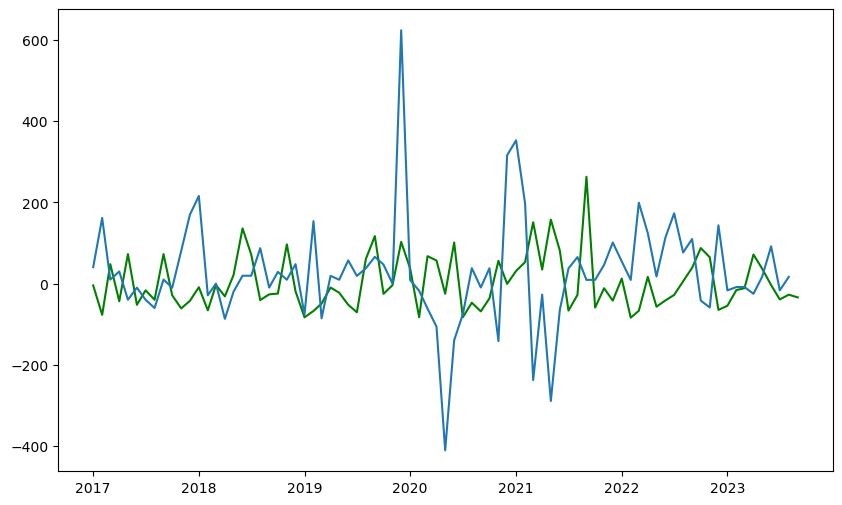

In [189]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(si_infl["date"].values, si_infl["gui_cycle"].values, label="epu_index", color="green")
plt.plot(si_infl["date"].values, si_infl["inflation"].values*100, label="inflation");

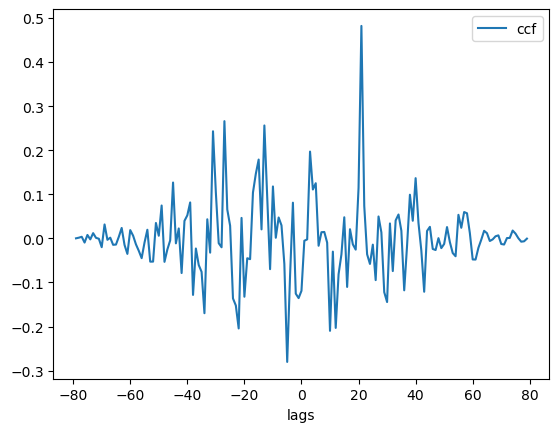

In [190]:
ccf_df = cross_correlation(si_infl["gui_cycle"][:-1], si_infl["inflation"][:-1])
ccf_df.plot(x="lags");

In [197]:
var_df = si_infl[["pca", "inflation"]][:-1]
# print(adf_test(var_df["epu_weighted"]), "\n", adf_test(var_df["inflation"]),
#       "\n", adf_test(var_df["inflation_gui"]))

In [198]:
length = len(si_infl.iloc[:])
train = int(length * 0.95)
test = length - train


model = VAR(endog=var_df[:train+1])

eval_lst = []
for i in range(1, 13):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)
    
eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,9.952179,10.136184,20999.645281,10.025716
1,2,9.817395,10.126394,18357.463999,9.940775
2,3,9.879939,10.315843,19556.707965,10.053826
3,4,9.881809,10.446580,19620.517236,10.106880
4,5,9.929583,10.625231,20628.012936,10.206522
5,6,10.030877,10.859464,22907.742097,10.360380
6,7,10.042321,11.005962,23290.807655,10.425091
7,8,10.082690,11.183555,24425.681942,10.519440
8,9,10.190880,11.431193,27485.353679,10.682330
9,10,10.188803,11.570849,27790.848243,10.735682


In [199]:
from statsmodels.tsa.vector_ar.vecm import VECM

best_mod = model.fit(2)
best_mod.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Jan, 2024
Time:                     18:02:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.1264
Nobs:                     75.0000    HQIC:                   9.94078
Log likelihood:          -570.993    FPE:                    18357.5
AIC:                      9.81740    Det(Omega_mle):         16134.5
--------------------------------------------------------------------
Results for equation pca
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                4.734526        11.848033            0.400           0.689
L1.pca               0.213099         0.106580            1.999           0.046
L1.inflation       -27.005505         9.219450           -2.929   

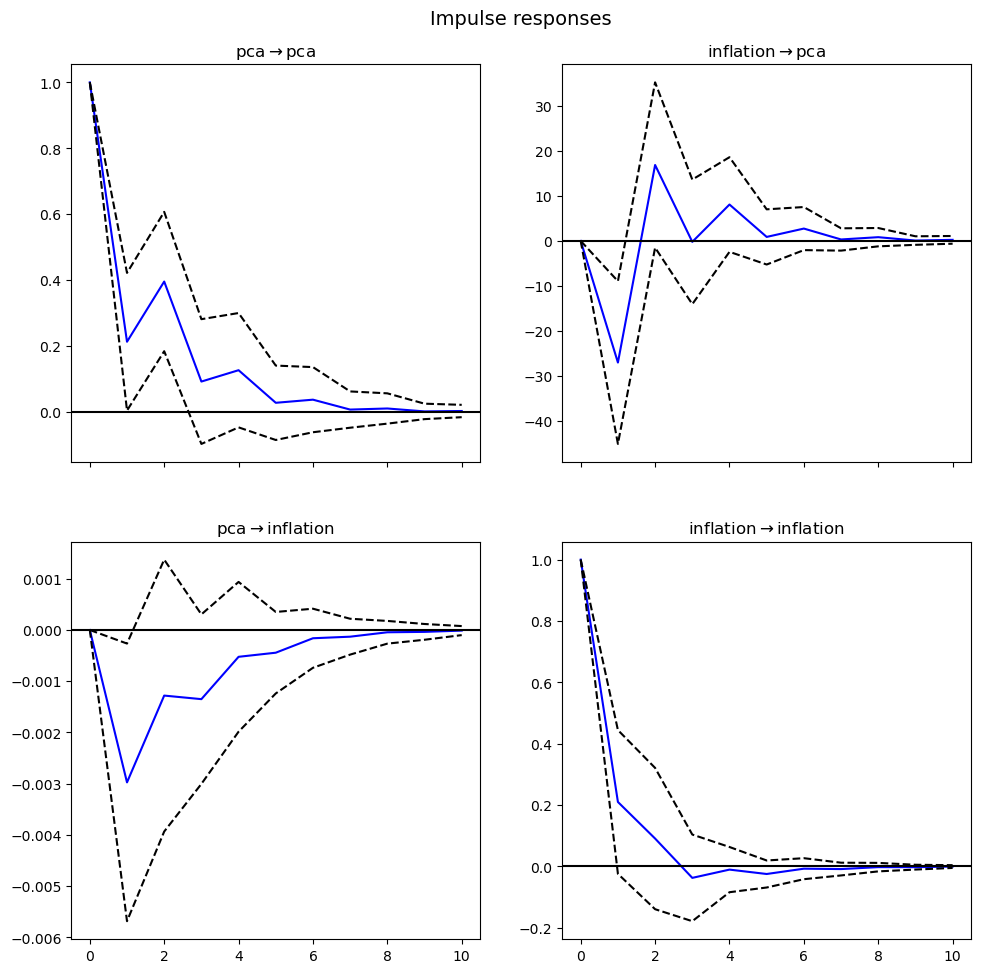

In [200]:
best_mod.irf().plot();

In [202]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(best_mod.resid)
out

array([2.01561145, 1.98004922])

In [203]:
var_forecast = best_mod.forecast(y=var_df.values[-test:], steps=test)
var_forecast_df = pd.DataFrame(var_forecast, index=var_df.index[-test:], columns=["var_inflation", "var_epu"])
var_df["date"] = si_infl["date"][var_df.index]


In [204]:
var_forecast_df["date"] = si_infl["date"][var_forecast_df.index]


In [205]:
fit_df = best_mod.fittedvalues.rename({"epu_index": "var_epu_index",
                                       "inflation": "var_inflation"}, axis=1)
fit_df = (pd.concat([fit_df, var_df.iloc[fit_df.index]], axis=1)
             .sort_values(by="date").reset_index(drop=True))

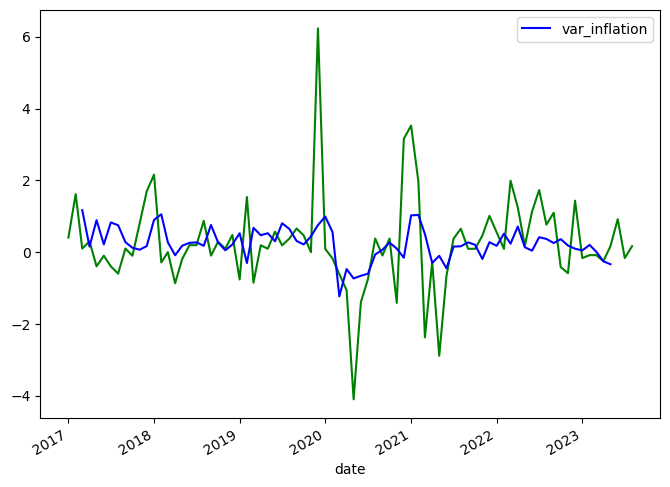

In [207]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(var_df["date"].values, var_df["inflation"].values, color="green")
fit_df.plot(x="date", y="var_inflation", ax=ax, color="blue")
# ax.plot(var_forecast_df['date'].values,
#         var_forecast_df["var_inflation"].values,
#         label="var_predict_test", color="blue", linestyle="--")
ax.plot()
plt.show();